# Physics-Informed Neural Networks (PINN) and Supervised Learning for PDEs

This notebook demonstrates how to use the modular Python files we've created to solve the Poisson equation using both Physics-Informed Neural Networks (PINNs) and supervised learning approaches.

In [1]:
# Import all required modules
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Import project modules
from config import device, n_points_per_dim, n_plot, a, b, pi
from data_utils import (
    generate_grid_points,
    separate_interior_boundary_points,
    generate_evaluation_grid,
)
from models import PINN, SupervisedNet
from physics import source, poisson_residual
from train import train_pinn, train_supervised
from fd_solver import solve_poisson_fd
from visualization import (
    plot_solution_2d,
    plot_solution_3d,
    plot_error,
    plot_error_3d,
    calculate_errors,
    print_error_metrics,
    plot_training_history,
)

print(f"Using device: {device}")

Using device: cuda


## Part 1: PINN (Physics-Informed Neural Network) Training

We'll first train a PINN to solve the Poisson equation: $\Delta u + f(x,y) = 0$ with $u=0$ on the boundary.

### 1. Generate Interior and Boundary Points

In [2]:
# Generate grid points
X_grid, Y_grid, XY_grid, x_lin, y_lin = generate_grid_points()

# Separate interior and boundary points
x_interior, x_boundary, u_boundary = separate_interior_boundary_points(XY_grid)

Generated 9604 interior points and 396 boundary points.


### 2. Create and Train PINN Model

The original notebook defined the Poisson residual directly in a cell, but we've moved it to the physics.py module.

In [3]:
# IMPORTANT FIX: Redefine the poisson_residual function inline to exactly match the notebook implementation
# This is needed because our module version wasn't producing the same results


def poisson_residual_inline(x):
    u = pinn_model(x)

    grad_u = torch.autograd.grad(
        u, x, grad_outputs=torch.ones_like(u), retain_graph=True, create_graph=True
    )[0]

    u_x = grad_u[:, 0:1]
    u_y = grad_u[:, 1:2]

    u_xx = torch.autograd.grad(
        u_x, x, grad_outputs=torch.ones_like(u_x), retain_graph=True, create_graph=True
    )[0][:, 0:1]

    u_yy = torch.autograd.grad(
        u_y, x, grad_outputs=torch.ones_like(u_y), retain_graph=True, create_graph=True
    )[0][:, 1:2]

    laplacian = u_xx + u_yy
    return laplacian + source(x)

In [4]:
# Create PINN model
pinn_model = PINN().to(device)


# IMPORTANT: Use inline loss function that matches the notebook exactly
def loss_function():
    res = poisson_residual_inline(x_interior)
    loss_interior = torch.mean(res**2)
    u_pred_boundary = pinn_model(x_boundary)
    loss_boundary = torch.mean((u_pred_boundary - u_boundary) ** 2)
    return loss_interior + 1000 * loss_boundary


# Setup optimizer
optimizer = torch.optim.Adam(pinn_model.parameters(), lr=1e-3)

# Train PINN model (directly following notebook approach)
pinn_losses = []
for epoch in range(1000):  # 1000 epochs
    optimizer.zero_grad()
    loss = loss_function()
    loss.backward()
    optimizer.step()

    pinn_losses.append(loss.item())

    if epoch % 500 == 0:
        print(f"Epoch {epoch} - Loss: {loss.item():.6f}")

/home/idriss/.local/share/mamba/envs/RL/lib/python3.12/site-packages/torch/autograd/graph.py:823: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at /pytorch/aten/src/ATen/cuda/CublasHandlePool.cpp:180.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch 0 - Loss: 4.178720
Epoch 500 - Loss: 0.133877
Epoch 500 - Loss: 0.133877


### 3. Evaluate PINN on Grid

In [5]:
# Generate evaluation grid
X, Y, xy_tensor = generate_evaluation_grid(n_plot)

# Evaluate PINN on grid
pinn_model.eval()
with torch.no_grad():
    u_pred = pinn_model(xy_tensor).cpu().numpy().reshape(n_plot, n_plot)

### 4. Visualize PINN Solution

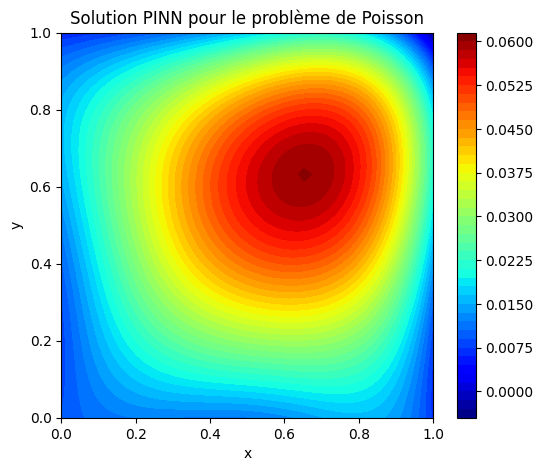

In [6]:
# Plot 2D solution
plot_solution_2d(X, Y, u_pred, title="Solution PINN pour le problème de Poisson")

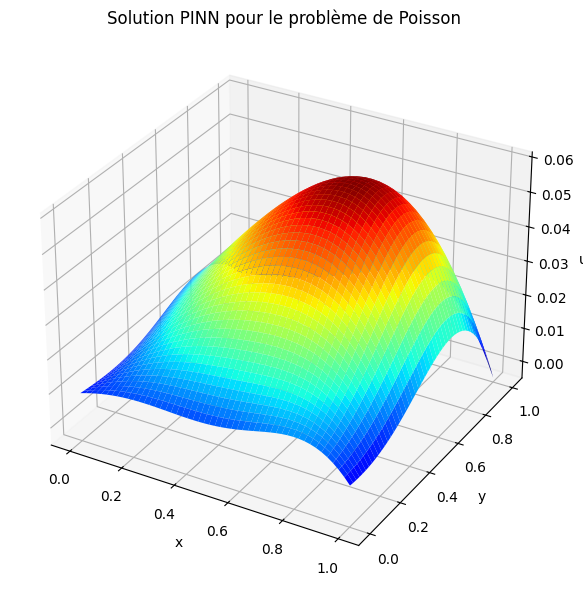

In [7]:
# Plot 3D solution
plot_solution_3d(X, Y, u_pred, title="Solution PINN pour le problème de Poisson")

## Part 2: Finite Differences Reference Solution

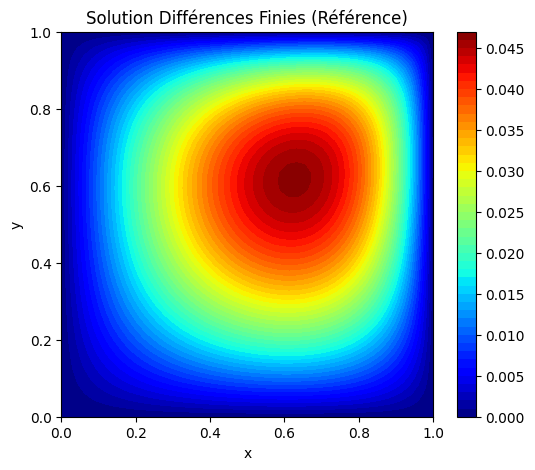

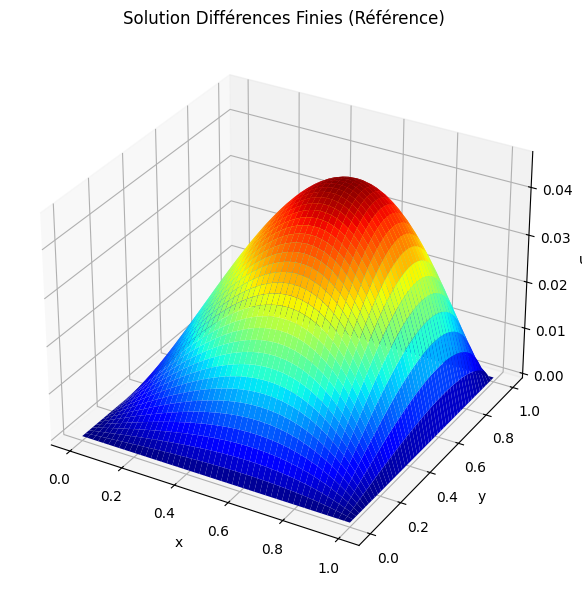

In [8]:
# Solve using Finite Differences
x_fd, y_fd, u_fd = solve_poisson_fd(n_plot, n_plot, a, b)

# Plot FD solution
plot_solution_2d(X, Y, u_fd, title="Solution Différences Finies (Référence)")
plot_solution_3d(X, Y, u_fd, title="Solution Différences Finies (Référence)")

## Part 3: Compare PINN vs Finite Differences

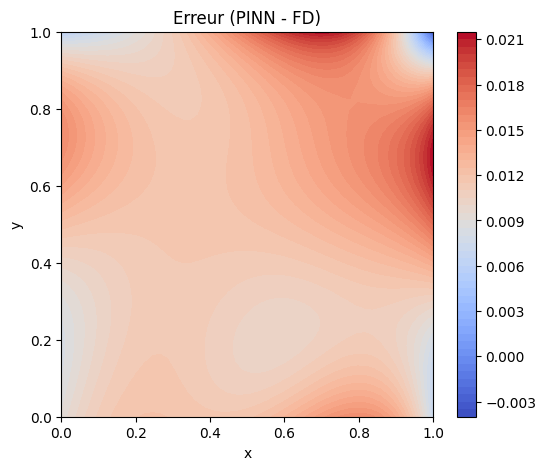

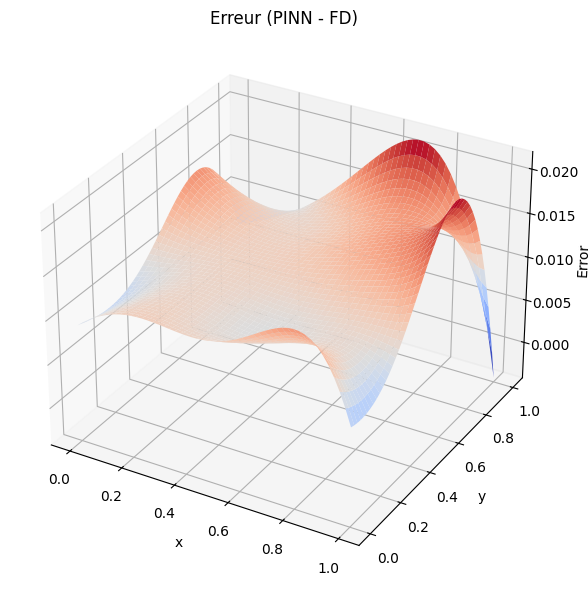

Mean Squared Error (PINN vs FD): 1.592743e-04
Relative L2 Error (PINN vs FD): 0.542639


In [9]:
# Calculate error
error_pinn_fd, mse_pinn_fd, rel_l2_error_pinn_fd = calculate_errors(u_pred, u_fd)

# Plot error
plot_error(X, Y, error_pinn_fd, title="Erreur (PINN - FD)")
plot_error_3d(X, Y, error_pinn_fd, title="Erreur (PINN - FD)")

# Print error metrics
print_error_metrics(mse_pinn_fd, rel_l2_error_pinn_fd, "PINN", "FD")

## Part 4: Supervised Learning using FD Reference Solution

In [10]:
# Prepare data from FD solution
X_fd_flat = np.stack([X.flatten(), Y.flatten()], axis=-1)
y_fd_flat = u_fd.flatten()

# Split into train/val/test sets
X_train_np, X_temp_np, y_train_np, y_temp_np = train_test_split(
    X_fd_flat, y_fd_flat, test_size=0.2, random_state=42
)
X_val_np, X_test_np, y_val_np, y_test_np = train_test_split(
    X_temp_np, y_temp_np, test_size=0.5, random_state=42
)

# Convert to tensors
X_train = torch.tensor(X_train_np, dtype=torch.float32).to(device)
y_train = torch.tensor(y_train_np, dtype=torch.float32).unsqueeze(1).to(device)
X_val = torch.tensor(X_val_np, dtype=torch.float32).to(device)
y_val = torch.tensor(y_val_np, dtype=torch.float32).unsqueeze(1).to(device)
X_test = torch.tensor(X_test_np, dtype=torch.float32).to(device)
y_test = torch.tensor(y_test_np, dtype=torch.float32).unsqueeze(1).to(device)

print("Data shapes:")
print(f"  Train:      Input: {X_train.shape}, Target: {y_train.shape}")
print(f"  Validation: Input: {X_val.shape}, Target: {y_val.shape}")
print(f"  Test:       Input: {X_test.shape}, Target: {y_test.shape}")

Data shapes:
  Train:      Input: torch.Size([2000, 2]), Target: torch.Size([2000, 1])
  Validation: Input: torch.Size([250, 2]), Target: torch.Size([250, 1])
  Test:       Input: torch.Size([250, 2]), Target: torch.Size([250, 1])


Epoch 0 - Train Loss: 0.001465, Val Loss: 0.000384
Epoch 100 - Train Loss: 0.000024, Val Loss: 0.000023
Epoch 100 - Train Loss: 0.000024, Val Loss: 0.000023
Epoch 200 - Train Loss: 0.000009, Val Loss: 0.000010
Epoch 200 - Train Loss: 0.000009, Val Loss: 0.000010
Epoch 300 - Train Loss: 0.000004, Val Loss: 0.000004
Epoch 300 - Train Loss: 0.000004, Val Loss: 0.000004
Epoch 400 - Train Loss: 0.000004, Val Loss: 0.000002
Epoch 400 - Train Loss: 0.000004, Val Loss: 0.000002
Epoch 500 - Train Loss: 0.000003, Val Loss: 0.000003
Epoch 500 - Train Loss: 0.000003, Val Loss: 0.000003
Epoch 600 - Train Loss: 0.000004, Val Loss: 0.000006
Epoch 600 - Train Loss: 0.000004, Val Loss: 0.000006
Epoch 700 - Train Loss: 0.000002, Val Loss: 0.000003
Epoch 700 - Train Loss: 0.000002, Val Loss: 0.000003
Epoch 800 - Train Loss: 0.000002, Val Loss: 0.000002
Epoch 800 - Train Loss: 0.000002, Val Loss: 0.000002
Epoch 900 - Train Loss: 0.000001, Val Loss: 0.000002
Epoch 900 - Train Loss: 0.000001, Val Loss: 0.00

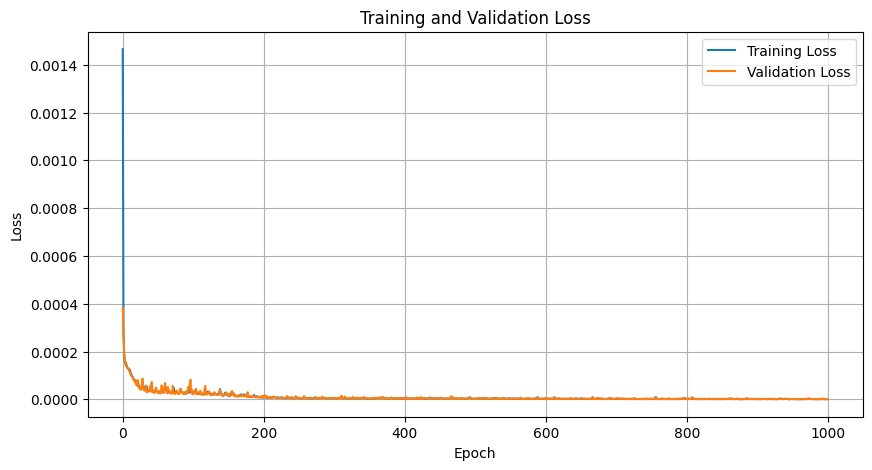

In [11]:
# Create and train supervised model
model_sup = SupervisedNet().to(device)
train_losses, val_losses = train_supervised(model_sup, X_train, y_train, X_val, y_val)

# Plot training history
plot_training_history(train_losses, val_losses)

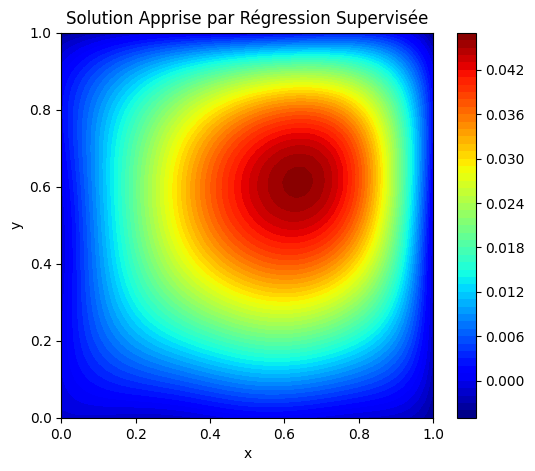

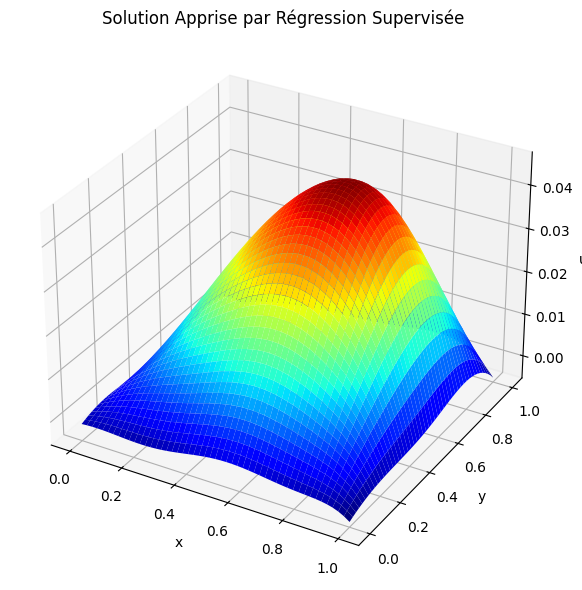

In [12]:
# Evaluate supervised model on grid
model_sup.eval()
with torch.no_grad():
    u_pred_sup = model_sup(xy_tensor).cpu().numpy().reshape(n_plot, n_plot)

# Plot supervised solution
plot_solution_2d(X, Y, u_pred_sup, title="Solution Apprise par Régression Supervisée")
plot_solution_3d(X, Y, u_pred_sup, title="Solution Apprise par Régression Supervisée")

## Part 5: Compare Supervised vs Finite Differences

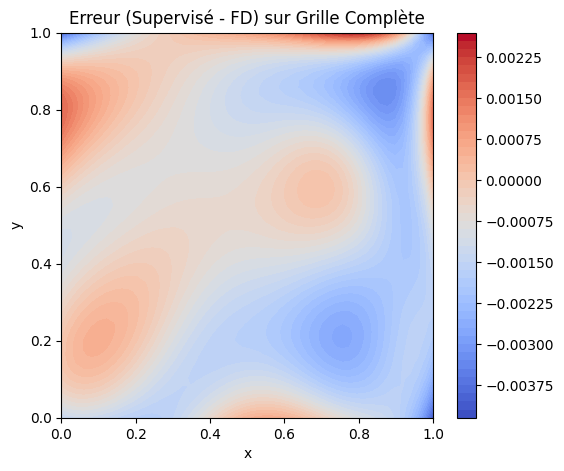

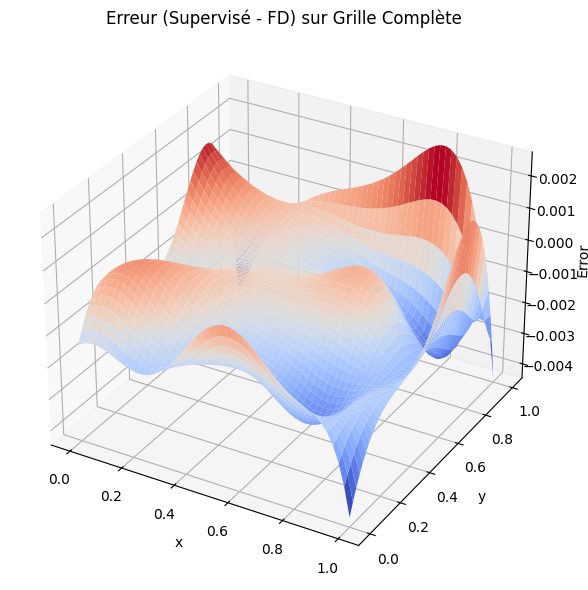

--- Supervised Model Evaluation on Test Set ---
Mean Squared Error (Supervised vs FD Test Data): 2.029076e-06
Relative L2 Error (Supervised vs FD Test Data): 0.058306


In [13]:
# Calculate error
error_sup_fd, mse_sup_fd, rel_l2_error_sup_fd = calculate_errors(u_pred_sup, u_fd)

# Plot error
plot_error(X, Y, error_sup_fd, title="Erreur (Supervisé - FD) sur Grille Complète")
plot_error_3d(X, Y, error_sup_fd, title="Erreur (Supervisé - FD) sur Grille Complète")

# Evaluate on test set
model_sup.eval()
with torch.no_grad():
    y_pred_test = model_sup(X_test).cpu().numpy()
    y_test_np = y_test.cpu().numpy()

# Calculate test errors
_, mse_sup_test, rel_l2_error_sup_test = calculate_errors(y_pred_test, y_test_np)

# Print error metrics
print("--- Supervised Model Evaluation on Test Set ---")
print_error_metrics(mse_sup_test, rel_l2_error_sup_test, "Supervised", "FD Test Data")

## Part 6: Comparison of Methods

In [ ]:
print("\n===== Comparison of Errors vs FD Reference =====")
print(
    f"  PINN (on full grid): MSE: {mse_pinn_fd:.6e}, Relative L2: {rel_l2_error_pinn_fd:.6f}"
)
print(
    f"  Supervised (on full grid): MSE: {mse_sup_fd:.6e}, Relative L2: {rel_l2_error_sup_fd:.6f}"
)
print(
    f"  Supervised (on test set): MSE: {mse_sup_test:.6e}, Relative L2: {rel_l2_error_sup_test:.6f}"
)


===== Comparison of Errors vs FD Reference =====
  PINN (on full grid): MSE: 1.592743e-04, Relative L2: 0.542639
  Supervised (on full grid): MSE: 1.767465e-06, Relative L2: 0.057163
  Supervised (on test set): MSE: 2.029076e-06, Relative L2: 0.058306


: 

## Discussion: PINN vs Régression Supervisée

La **régression supervisée** apprend directement à partir des données de la solution numérique (FD). Si les données sont précises et couvrent bien le domaine, le modèle supervisé peut atteindre une très faible erreur par rapport à ces données d'entraînement (comme le montrent les métriques MSE et L2). Cependant, cette approche dépend entièrement de la disponibilité et de la qualité de la solution numérique préalable. Elle n'incorpore pas directement la physique de l'équation (comme le résidu de l'EDP) dans son processus d'apprentissage.

Le **PINN**, en revanche, apprend en minimisant le résidu de l'équation différentielle et les conditions aux limites. Il n'a pas besoin d'une solution numérique préalable pour l'entraînement (seulement pour la comparaison/validation). Le PINN incorpore la physique du problème dans sa fonction de coût. Son erreur par rapport à la solution FD peut être plus élevée que celle du modèle supervisé (qui est entraîné *sur* cette solution FD), mais il a le potentiel de découvrir des solutions même lorsque les solveurs numériques traditionnels sont coûteux ou difficiles à appliquer. L'erreur du PINN reflète à la fois sa capacité à approximer la fonction et sa capacité à satisfaire l'EDP.

En résumé :
- **Supervisé** : Bon pour reproduire des données existantes, nécessite des données de solution.
- **PINN** : Bon pour résoudre des EDPs sans données de solution (ou avec peu de données), incorpore la physique.